**Brian Blaylock**  
**June 25, 2020**  
COVID-19 Era



# 🏗 Demo: How to download a **subset** of variables from a HRRR file.
HRRR grib2 files can be downloaded from the [University of Utah's HRRR archive](http://hrrr.chpc.utah.edu/) on the CHPC Pando archive system. You may also get HRRR grib2 files from the [NOAA Operational Model Archive and Distribution System (NOMADS)](https://nomads.ncep.noaa.gov/), but only for the today's and yesterday's runs.

My other notebook shows [how to download many GRIB2 files from Pando or NOMADS]('https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/demo_download_hrrr_archive.ipynb'). This notebook shows how to download **just select parts of the file** instead of the full file. We have to use the `cURL` command line program to download a range of bytes from a file. Fortunatly, `cURL` should be included in your Anaconda environment.

You first need to know how GRIB files work. The GRIB file format is made up of gridded binary "fields" stacked on top of one another. Each GRIB "field" contains the information for a single variable at a certain level. We can target one or more of these fields in the file and just download the layers we want by downloading a *range of bytes* in the file. You should know that it is not possible to download a subset of the file based on geographic region because the byte location for specific data in the grid are not known, just the first and last byte of the variable "field".

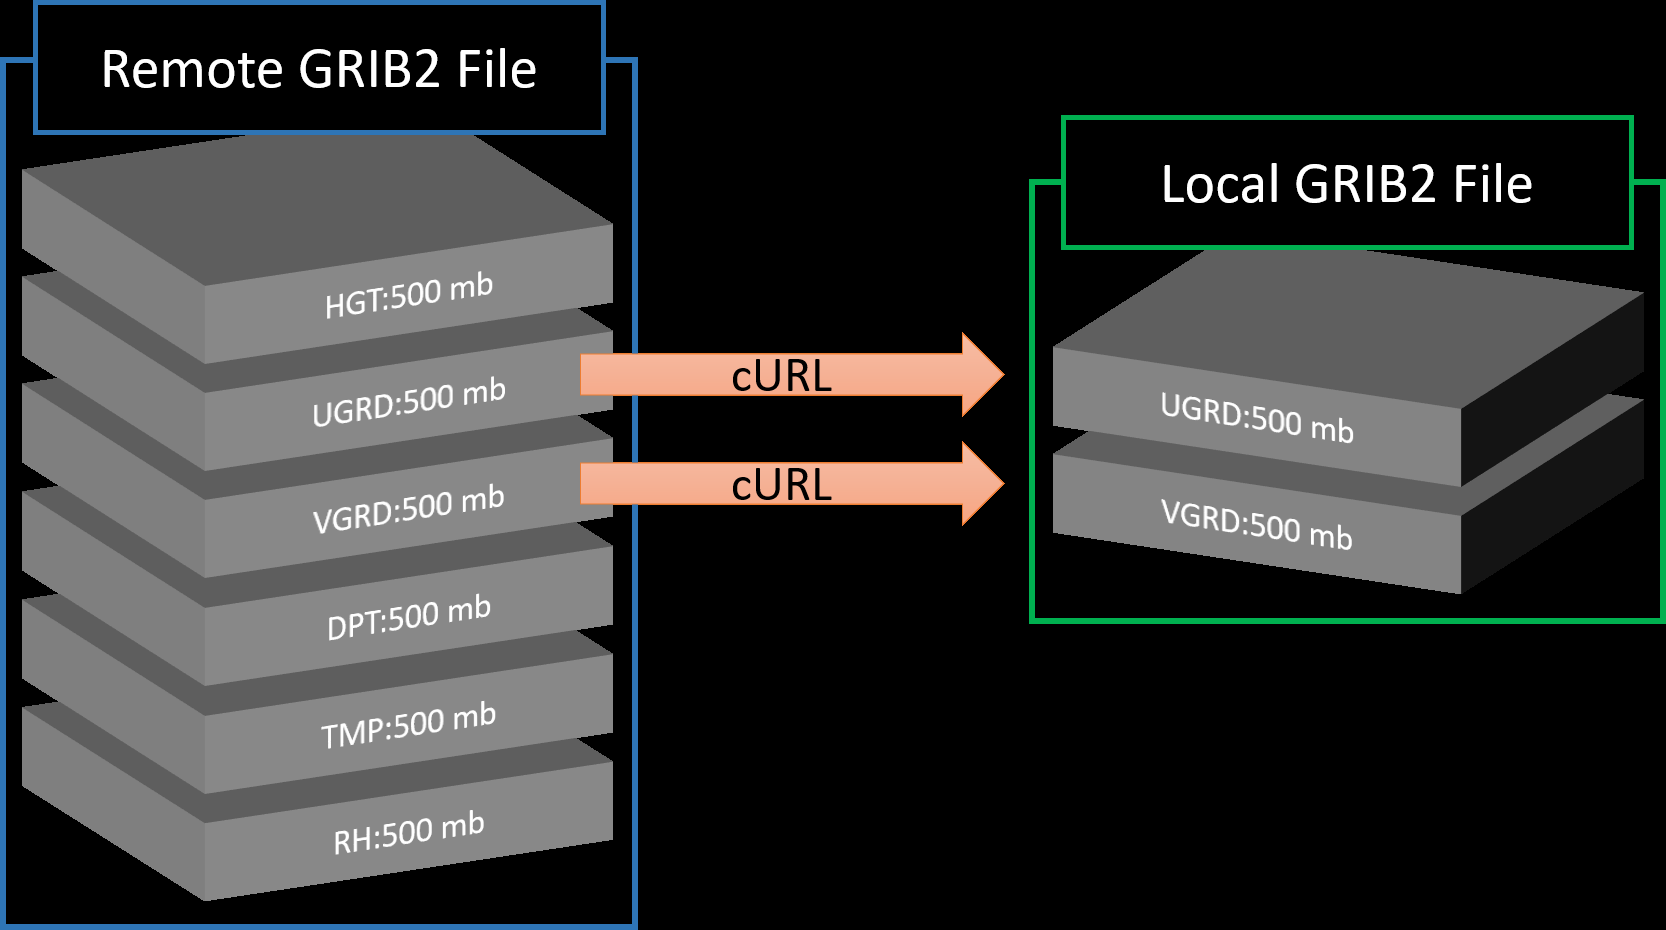
![GRIB2_file_cURL.png](./GRIB2_file_cURL.png)

---
🌐 HRRR Archive Website: http://hrrr.chpc.utah.edu/  
📧 Brian Blaylock blaylockbk@gmail.com  
✒ Citation this details:
> Blaylock B., J. Horel and S. Liston, 2017: Cloud Archiving and Data Mining of High Resolution Rapid Refresh Model Output. Computers and Geosciences. 109, 43-50. https://doi.org/10.1016/j.cageo.2017.08.005


---

Let's start by importing some modules we will use...



In [1]:
import os
import re              # Used to search for a string in a line
import requests        # Used to check if a URL exists

Given the URL for a HRRR GRIB2 file located on Pando, we need to read the `.idx` file to find the locatio of the beginning byte for each of the variables. The URL for a file's `.idx` file is just the file URL with '.idx' append to the end.

In [2]:
# Example file
url = 'https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200624/hrrr.t01z.wrfsfcf17.grib2'
idx = url + '.idx'
idx

'https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200624/hrrr.t01z.wrfsfcf17.grib2.idx'

Lets read the .idx file and look at the first ten lines

In [3]:
# Make a request for the .idx file for the above URL
r = requests.get(url+'.idx')

# Check that the file exists. If there isn't an index, you will get a 404 error.
if not r.ok: 
    print('Status Code:', r.status_code, r.reason)

# Read the text lines of the request
lines = r.text.split('\n')

# Just look at the first 10 lines
lines[:10]

['1:0:d=2020062401:REFC:entire atmosphere:17 hour fcst:',
 '2:490289:d=2020062401:RETOP:cloud top:17 hour fcst:',
 '3:681173:d=2020062401:VIL:entire atmosphere:17 hour fcst:',
 '4:943024:d=2020062401:VIS:surface:17 hour fcst:',
 '5:2286009:d=2020062401:REFD:1000 m above ground:17 hour fcst:',
 '6:2547950:d=2020062401:REFD:4000 m above ground:17 hour fcst:',
 '7:2723918:d=2020062401:REFD:263 K level:17 hour fcst:',
 '8:2901079:d=2020062401:GUST:surface:17 hour fcst:',
 '9:4074410:d=2020062401:UGRD:250 mb:17 hour fcst:',
 '10:4855103:d=2020062401:VGRD:250 mb:17 hour fcst:']

You see above that each line in the index file describes each GRIB "field" or "grid" in the file. Here is a break down of the 10th line...
- `10` - The GRIB message number.
- `4855103` - The beginning byte for this variable.
- `d=2020062401` - The datetime the model was initialized YYYYMMDDHH.
- `VGRD` - The GRIB variable short name.
- `250 mb` - The level of the data.
- `17 hour fcst` - The forecast lead time.

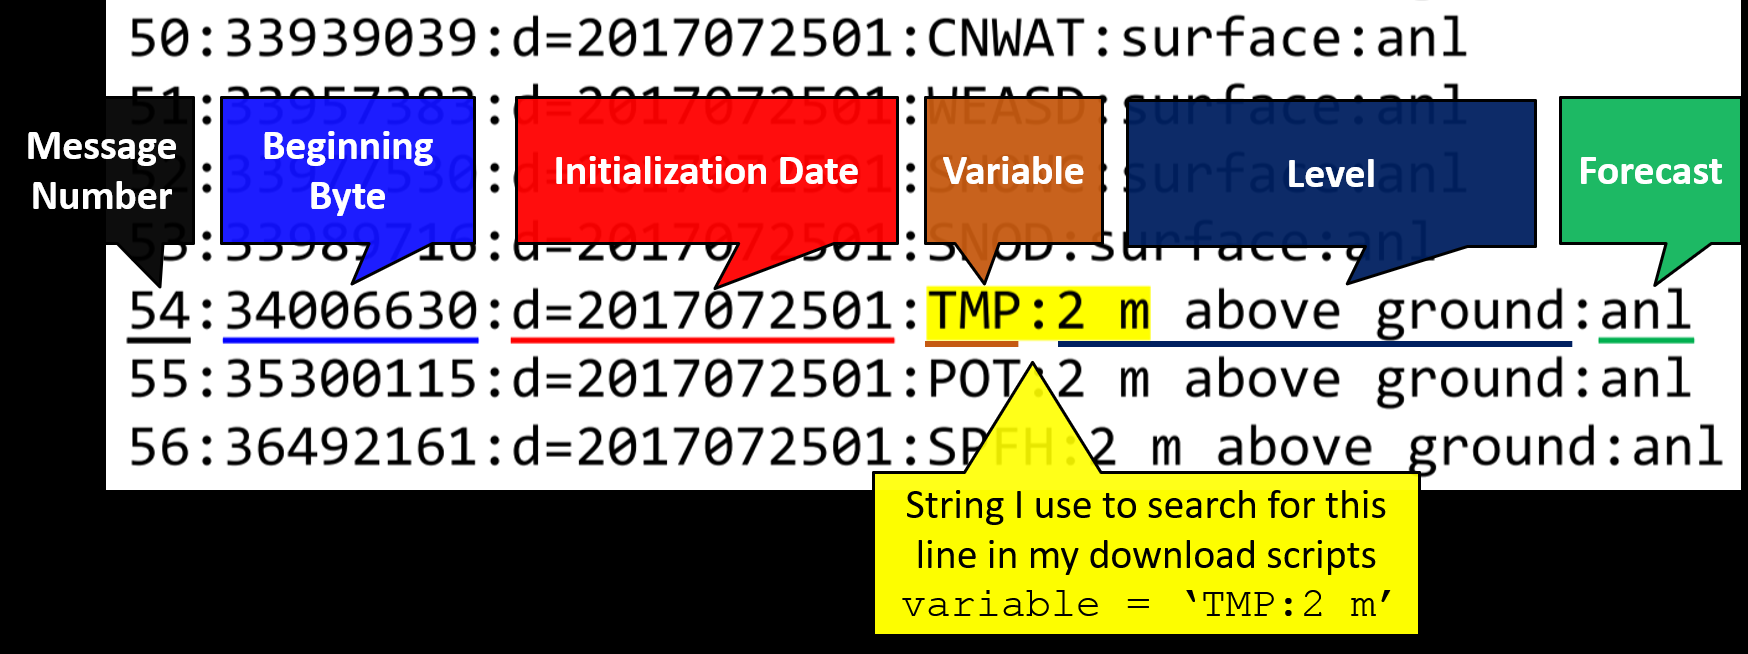

To download a range of bytes, we need the beginning byte for the variable we want and the beginning byte for the next variable. 

We will define a string look for in the file and loop over every line until we find the "fields" we want to download. Generally, you will define a search string based on the variable type and level you want. 

The way the line search I wrote for you allows the use of *regular expressions*. What are regular experssions? [Here is a cheat sheet](https://link.medium.com/7rxduD2e06).

For example: 

    search_this = 'TMP:500 mb'    # Temperature at the 500 mb variables
    search_this = ':500 mb'       # all the 500 mb variables
    search_this = 'SBT:'          # All Simulated brightness temperature
    search_this = 'APCP'          # All accumulated precipiation
    search_this = '.GRD:80 m'     # U and V wind components at 80 meters above ground
    search_this = ':(U|V)GRD:'    # U and V wind components at all levels
    search_this = ':(DPT|TMP):'   # Dew Point and Temperature at all levels
    #get_variable = ':REFC:'      # Composite Reflectivity
    #get_variable = ':surface:'   # All variables valid at the surface.


In [4]:
# For this example, lets search for all U and V wind fields.
search_this = ':(U|V)GRD:'

# Search expression
expr = re.compile(search_this)

# Store the byte ranges we find for our variables in a dictionary
#     {byte-range-as-string: line}
byte_ranges = {}
for n, line in enumerate(lines, start=1):
    # n is the line number (starting from 1) so that when we call for 
    # `lines[n]` it will give us the next line. (Clear as mud??)
    
    # Use the compiled regular expression to search the line
    if expr.search(line):   
        # aka, if the line contains the string we are looking for...
        
        # Get the beginning byte in the line we found
        parts = line.split(':')
        rangestart = int(parts[1])
        
        # Get the beginning byte in the next line...
        if n+1 < len(lines):
            # ...if there is a next line
            parts = lines[n].split(':')
            rangeend = int(parts[1])
        else:
            # ...if there isn't a next line, then go to the end of the file.
            rangeend = ''
        
        # Store the byte-range string in our dictionary, 
        # and keep the line information too so we can refer back to it.
        byte_ranges[f'{rangestart}-{rangeend}'] = line

# Now lets take a look at what we gathered...
byte_ranges

{'4074410-4855103': '9:4074410:d=2020062401:UGRD:250 mb:17 hour fcst:',
 '4855103-5621119': '10:4855103:d=2020062401:VGRD:250 mb:17 hour fcst:',
 '5621119-6409673': '11:5621119:d=2020062401:UGRD:300 mb:17 hour fcst:',
 '6409673-7182342': '12:6409673:d=2020062401:VGRD:300 mb:17 hour fcst:',
 '9396709-9988321': '16:9396709:d=2020062401:UGRD:500 mb:17 hour fcst:',
 '9988321-10587398': '17:9988321:d=2020062401:VGRD:500 mb:17 hour fcst:',
 '12910456-13516093': '21:12910456:d=2020062401:UGRD:700 mb:17 hour fcst:',
 '13516093-14130774': '22:13516093:d=2020062401:VGRD:700 mb:17 hour fcst:',
 '16569914-17195734': '26:16569914:d=2020062401:UGRD:850 mb:17 hour fcst:',
 '17195734-17825413': '27:17195734:d=2020062401:VGRD:850 mb:17 hour fcst:',
 '19521842-20158378': '30:19521842:d=2020062401:UGRD:925 mb:17 hour fcst:',
 '20158378-20789480': '31:20158378:d=2020062401:VGRD:925 mb:17 hour fcst:',
 '22524126-23158000': '34:22524126:d=2020062401:UGRD:1000 mb:17 hour fcst:',
 '23158000-23783838': '35:231

Now that we have the byte ranges for each line we want, lets download each item with `cURL`. Note that cURL is a command-line tool. We can execute a cURL statement with `os.system`. The downloaded content will be appended to the end of the file we create.

In [5]:
# What should we name the file we download the data into?

# We want the filename to include the model run date (we can get that from the line information)
runDate = list(byte_ranges.items())[0][1].split(':')[2][2:-2]

# And we want to label the filename as a "subset"
outFile = '_'.join(['subset', runDate, url.split('/')[-1]])


# Ok, this file name looks good to me. It's unique and says what it is.
outFile

'subset_20200624_hrrr.t01z.wrfsfcf17.grib2'

We will a loop and cURL to download each "field" of the file we searched for...

In [6]:
for i, (byteRange, line) in enumerate(byte_ranges.items()):
    print('Working on line', line)
    
    if i == 0:
        # If we are working on the first item, overwrite the existing file or create a new one.
        curl = f'curl -s --range {byteRange} {url} > {outFile}'
    else:
        # If we are working on not the first item, append the existing file.
        curl = f'curl -s --range {byteRange} {url} >> {outFile}'
    
    print('I am executing this cURL command...')
    print(f'  💾 {curl}\n')
    os.system(curl)

Working on line 9:4074410:d=2020062401:UGRD:250 mb:17 hour fcst:
I am executing this cURL command...
  💾 curl -s --range 4074410-4855103 https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200624/hrrr.t01z.wrfsfcf17.grib2 > subset_20200624_hrrr.t01z.wrfsfcf17.grib2

Working on line 10:4855103:d=2020062401:VGRD:250 mb:17 hour fcst:
I am executing this cURL command...
  💾 curl -s --range 4855103-5621119 https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200624/hrrr.t01z.wrfsfcf17.grib2 >> subset_20200624_hrrr.t01z.wrfsfcf17.grib2

Working on line 11:5621119:d=2020062401:UGRD:300 mb:17 hour fcst:
I am executing this cURL command...
  💾 curl -s --range 5621119-6409673 https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200624/hrrr.t01z.wrfsfcf17.grib2 >> subset_20200624_hrrr.t01z.wrfsfcf17.grib2

Working on line 12:6409673:d=2020062401:VGRD:300 mb:17 hour fcst:
I am executing this cURL command...
  💾 curl -s --range 6409673-7182342 https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200624/hrrr.t01z.wrfsfcf17.grib2 

Now let's look at the file we just created with `wgrib2`...You will see that it is a valid GRIB2 file with data in it. 

> Note: `wgrib2` is only available for Linux machines (you could install it on Windows if you want a big headache). If it isn't installed in your environment, you can download it via conda install. `conda install -c conda-forge wgrib2`. If you are on a Windows PC, don't sweat this part...there are other ways to look at a GRIB2 file (like with pygrib or xarray).

In [7]:
%%bash
wgrib2 ./subset_20200624_hrrr.t01z.wrfsfcf17.grib2

1:0:d=2020062401:UGRD:250 mb:17 hour fcst:
2:780694:d=2020062401:VGRD:250 mb:17 hour fcst:
3:1546711:d=2020062401:UGRD:300 mb:17 hour fcst:
4:2335266:d=2020062401:VGRD:300 mb:17 hour fcst:
5:3107936:d=2020062401:UGRD:500 mb:17 hour fcst:
6:3699549:d=2020062401:VGRD:500 mb:17 hour fcst:
7:4298627:d=2020062401:UGRD:700 mb:17 hour fcst:
8:4904265:d=2020062401:VGRD:700 mb:17 hour fcst:
9:5518947:d=2020062401:UGRD:850 mb:17 hour fcst:
10:6144768:d=2020062401:VGRD:850 mb:17 hour fcst:
11:6774448:d=2020062401:UGRD:925 mb:17 hour fcst:
12:7410985:d=2020062401:VGRD:925 mb:17 hour fcst:
13:8042088:d=2020062401:UGRD:1000 mb:17 hour fcst:
14:8675963:d=2020062401:VGRD:1000 mb:17 hour fcst:
15:9301802:d=2020062401:UGRD:80 m above ground:17 hour fcst:
16:10496858:d=2020062401:VGRD:80 m above ground:17 hour fcst:
17:11643066:d=2020062401:UGRD:10 m above ground:17 hour fcst:
18:12844033:d=2020062401:VGRD:10 m above ground:17 hour fcst:


---

## Put it all together
This next part is that same thing as above, but puts it together into a function you can use to download parts of a HRRR GRIB2 file from a URL.

In [8]:
import os
import re              # Used to search for a string in a line
import requests        # Used to check if a URL exists

def download_HRRR_subset(url, searchString, SAVEDIR='./'):
    """
    Download a subset of GRIB fields from a HRRR file.
    
    This assumes there is an index (.idx) file available for the file.
    
    Parameters
    ----------
    url : string
        The URL for the HRRR file you are trying to download. There must be an 
        index file for the GRIB2 file. For example, if 
        ``url='https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200624/hrrr.t01z.wrfsfcf17.grib2'``,
        then ``https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200624/hrrr.t01z.wrfsfcf17.grib2.idx``
        must also exist on the server.
    searchString : str
        The string you are looking for in each line of the index file. 
        Take a look at the 
        .idx file at https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200624/hrrr.t01z.wrfsfcf17.grib2.idx
        to get familiar with what is in each line.
        Also look at this webpage: http://hrrr.chpc.utah.edu/HRRR_archive/hrrr_sfc_table_f00-f01.html
        for additional details.**You should focus on the variable and level 
        field for your searches**.
        
        You may use regular expression syntax to customize your search. 
        Check out this regulare expression cheatsheet:
        https://link.medium.com/7rxduD2e06
        
        Here are a few examples that can help you get started
        
        ================ ===============================================
        ``searchString`` Messages that will be downloaded
        ================ ===============================================
        ':TMP:2 m'       Temperature at 2 m.
        ':TMP:'          Temperature fields at all levels.
        ':500 mb:'       All variables on the 500 mb level.
        ':APCP:'         All accumulated precipitation fields.
        ':UGRD:10 m:'    U wind component at 10 meters.
        ':(U|V)GRD:'     U and V wind component at all levels.
        ':.GRD:'         (Same as above)
        ':(TMP|DPT):'    Temperature and Dew Point for all levels .
        ':(TMP|DPT|RH):' TMP, DPT, and Relative Humidity for all levels.
        ':REFC:'         Composite Reflectivity
        ':surface:'      All variables at the surface.
        ================ ===============================================    
        
    SAVEDIR : string
        Directory path to save the file, default is the current directory.
    
    Returns
    -------
    The path and name of the new file.
    """
    # Ping Pando first. This *might* prevent a "bad handshake" error.
    if True:
        try:
            requests.head('https://pando-rgw01.chpc.utah.edu/')
        except:
            print('bad handshake...am I able to on?')
            pass
    
    # Make SAVEDIR if path doesn't exist
    if not os.path.exists(SAVEDIR):
        os.makedirs(SAVEDIR)
        print(f'Created directory: {SAVEDIR}')

    
    # Make a request for the .idx file for the above URL
    idx = url + '.idx'
    r = requests.get(idx)

    # Check that the file exists. If there isn't an index, you will get a 404 error.
    if not r.ok: 
        print('❌ SORRY! Status Code:', r.status_code, r.reason)
        print(f'❌ It does not look like the index file exists: {idx}')

    # Read the text lines of the request
    lines = r.text.split('\n')
    
    # Search expression
    expr = re.compile(searchString)

    # Store the byte ranges in a dictionary
    #     {byte-range-as-string: line}
    byte_ranges = {}
    for n, line in enumerate(lines, start=1):
        # n is the line number (starting from 1) so that when we call for 
        # `lines[n]` it will give us the next line. (Clear as mud??)

        # Use the compiled regular expression to search the line
        if expr.search(line):   
            # aka, if the line contains the string we are looking for...

            # Get the beginning byte in the line we found
            parts = line.split(':')
            rangestart = int(parts[1])

            # Get the beginning byte in the next line...
            if n+1 < len(lines):
                # ...if there is a next line
                parts = lines[n].split(':')
                rangeend = int(parts[1])
            else:
                # ...if there isn't a next line, then go to the end of the file.
                rangeend = ''

            # Store the byte-range string in our dictionary, 
            # and keep the line information too so we can refer back to it.
            byte_ranges[f'{rangestart}-{rangeend}'] = line
    
    # What should we name the file we save this data to?
    # Let's name it something like `subset_20200624_hrrr.t01z.wrfsfcf17.grib2`
    runDate = list(byte_ranges.items())[0][1].split(':')[2][2:-2]
    outFile = '_'.join(['subset', runDate, url.split('/')[-1]])
    outFile = os.path.join(SAVEDIR, outFile)
    
    for i, (byteRange, line) in enumerate(byte_ranges.items()):
        
        num, byte, date, var, level, forecast, _ = line.split(':')
        print(f'  Downloading GRIB line [{num}]: variable={var}, level={level}, forecast={forecast}')

        if i == 0:
            # If we are working on the first item, overwrite the existing file.
            curl = f'curl -s --range {byteRange} {url} > {outFile}'
        else:
            # If we are working on not the first item, append the existing file.
            curl = f'curl -s --range {byteRange} {url} >> {outFile}'
        os.system(curl)
        
    print(f'✅ Success! Searched for [{searchString}] and got [{len(byte_ranges)}] files. Saved as {outFile}')
    
    return outFile

### Examples

In [9]:
url = 'https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200624/hrrr.t01z.wrfsfcf17.grib2'

In [10]:
# Download u-component wind speeds at all available levels
download_HRRR_subset(url, ':UGRD:')

✅ Success! Searched for [:UGRD:] and got [9] files. Saved as ./subset_20200624_hrrr.t01z.wrfsfcf17.grib2


'./subset_20200624_hrrr.t01z.wrfsfcf17.grib2'

In [11]:
%%bash
wgrib2 ./subset_20200624_hrrr.t01z.wrfsfcf17.grib2

1:0:d=2020062401:UGRD:250 mb:17 hour fcst:
2:780694:d=2020062401:UGRD:300 mb:17 hour fcst:
3:1569249:d=2020062401:UGRD:500 mb:17 hour fcst:
4:2160862:d=2020062401:UGRD:700 mb:17 hour fcst:
5:2766500:d=2020062401:UGRD:850 mb:17 hour fcst:
6:3392321:d=2020062401:UGRD:925 mb:17 hour fcst:
7:4028858:d=2020062401:UGRD:1000 mb:17 hour fcst:
8:4662733:d=2020062401:UGRD:80 m above ground:17 hour fcst:
9:5857789:d=2020062401:UGRD:10 m above ground:17 hour fcst:


In [12]:
# Download TMP, DPT, and RH at 500 mb and 700 mb
download_HRRR_subset(url, ':(TMP|DPT|RH):(500|700) mb')

✅ Success! Searched for [:(TMP|DPT|RH):(500|700) mb] and got [4] files. Saved as ./subset_20200624_hrrr.t01z.wrfsfcf17.grib2


'./subset_20200624_hrrr.t01z.wrfsfcf17.grib2'

In [13]:
%%bash
wgrib2 ./subset_20200624_hrrr.t01z.wrfsfcf17.grib2

1:0:d=2020062401:TMP:500 mb:17 hour fcst:
2:545502:d=2020062401:DPT:500 mb:17 hour fcst:
3:1544471:d=2020062401:TMP:700 mb:17 hour fcst:
4:2109950:d=2020062401:DPT:700 mb:17 hour fcst:


In [14]:
# Download u- and v-component wind at 10 m above ground
download_HRRR_subset(url, ':.GRD:10 m')

✅ Success! Searched for [:.GRD:10 m] and got [2] files. Saved as ./subset_20200624_hrrr.t01z.wrfsfcf17.grib2


'./subset_20200624_hrrr.t01z.wrfsfcf17.grib2'

In [15]:
%%bash
wgrib2 ./subset_20200624_hrrr.t01z.wrfsfcf17.grib2

1:0:d=2020062401:UGRD:10 m above ground:17 hour fcst:
2:1200967:d=2020062401:VGRD:10 m above ground:17 hour fcst:


---
---
#### Notes

I was looking for a non-curl method to download, but couldn't find one. I have not found a way to download a range of bytes with the `requests` library. Primarily because `requests` canot do a `seek` on the GRIB2 files.

In [16]:
url = 'https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20200624/hrrr.t01z.wrfsfcf17.grib2'
r = requests.get(url, stream=True)

# Range of bytes I want
start_byte = 11260176
end_byte = 17825413

# Move stream to the firt byte we want
r.raw.seek(start_byte)

UnsupportedOperation: seek

But I can read from the begining of the file to a byte, but this isn't helpful for just getting a GRIB message from the middle of the file.

In [18]:
import io

r = requests.get(url, stream=True)

with open('smallFile.grib2', 'wb') as f:
    f.write(io.BytesIO(r.raw.read(end_byte)).getbuffer())

In [19]:
%%bash
wgrib2 smallFile.grib2

1:0:d=2020062401:REFC:entire atmosphere:17 hour fcst:
2:490289:d=2020062401:RETOP:cloud top:17 hour fcst:
3:681173:d=2020062401:VIL:entire atmosphere:17 hour fcst:
4:943024:d=2020062401:VIS:surface:17 hour fcst:
5:2286009:d=2020062401:REFD:1000 m above ground:17 hour fcst:
6:2547950:d=2020062401:REFD:4000 m above ground:17 hour fcst:
7:2723918:d=2020062401:REFD:263 K level:17 hour fcst:
8:2901079:d=2020062401:GUST:surface:17 hour fcst:
9:4074410:d=2020062401:UGRD:250 mb:17 hour fcst:
10:4855103:d=2020062401:VGRD:250 mb:17 hour fcst:
11:5621119:d=2020062401:UGRD:300 mb:17 hour fcst:
12:6409673:d=2020062401:VGRD:300 mb:17 hour fcst:
13:7182342:d=2020062401:HGT:500 mb:17 hour fcst:
14:7852240:d=2020062401:TMP:500 mb:17 hour fcst:
15:8397741:d=2020062401:DPT:500 mb:17 hour fcst:
16:9396709:d=2020062401:UGRD:500 mb:17 hour fcst:
17:9988321:d=2020062401:VGRD:500 mb:17 hour fcst:
18:10587398:d=2020062401:HGT:700 mb:17 hour fcst:
19:11260176:d=2020062401:TMP:700 mb:17 hour fcst:
20:11825654:d=